
# <center>Book Genre Predictor</center>

## Introduction
In this mini-project, we're going to use word-count frequencies from a variety of books (with labeled genres) to build a book genre predicting engine. The content in this mini-project was inspired by DataCamp's project *Word frequency in Moby Dick* and DataCamp's course *Unsupervised Learning in Python*.

For the source of our books, we will be using [Project Gutenberg](http://www.gutenberg.org/), a fantastic website that offers over 56,000 free books for which copyright has expired (as such, these will generally be relatively old books). In the [terms of use](http://www.gutenberg.org/wiki/Gutenberg:Terms_of_Use), the website states that Project Gutenberg is intended for human users only; please don't use a crawler to directly download a massive amount of books--the bandwidth is expensive. Before seeing the ToS, I started writing a script that would download books for me and received a temporary IP ban, so I will not be providing any of that code here. Because of this, we will use only a small number books for both the training set and the test set.

## Approach
The overall plan is as follows:
* **Gather books** We will obtain 5 books for each of 6 genres.
* **Format books** To properly format the books, we first combine the 5 books per genre into one large file. We then extract all the individual words from the file, convert to lowercase, and remove common *stopwords*.
* **TF-IDF** [(Term frequency-inverse document frequency)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) This step is equivalent to a count vectorizer followed by a TFIDF transform.
* **NMF** [(Non-negative matrix factorization)](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) In this step, we reduce the massive dimensionality of the TF-IDF matrix to a very small feature matrix.
* **Compute Similarity** Finally, we compute the similarity between the book of choice and the genres respective normalized features.

Note that we will tie the final three steps all together in a function along with the test book.

## Gather Books
I have chosen 3 non-fiction and 3 fiction genres. We will use 5 books from each of these genres to build the vocabulary list. No author will have more than 1 book in the training set.

**Classic Fiction**
* "Pride and Prejudice" by Jane Austen
* "A Tale of Two Cities" by Charles Dickens
* "Adventures of Huckleberry Finn" by Mark Twain
* "Moby Dick; Or, The Whale" by Herman Melville
* "Ulysses" by James Joyce


**Science Fiction**
* "The Time Machine" by H. G. Wells
* "2 B R 0 2 B" by Kurt Vonnegut
* "Second Variety" by Philip K. Dick
* "Youth" by Isaac Asimov
* "In the Year 2889" by Jules Verne and Michel Verne


**Crime**
* "Dead Men Tell No Tales" by E. W. Hornung
* "Murder in the Gunroom" by H. Beam Piper
* "Arsene Lupin" by Maurice Leblanc
* "The Amateur Cracksman" by E. W. Hornung
* "An African Millionaire: Episodes in the Life of the Illustrious Colonel Clay" by Grant Allen


**Politics**
* "Leviathan" by Thomas Hobbes
* "The Communist Manifesto" by Friedrich Engels and Karl Marx
* "Second Treatise of Government" by John Locke
* "Utopia" by Saint Thomas More
* "The Declaration of Independence of The United States of America" by Thomas Jefferson


**Biography**
* "Real Soldiers of Fortune" by Richard Harding Davis
* "Queen Victoria" by Lytton Strachey
* "The Every-day Life of Abraham Lincoln" by Francis F. Browne
* "Famous Men of the Middle Ages" by John H. Haaren and Addison B. Poland
* "Susan B. Anthony" by Alma Lutz


**Mathematics/Science**
* "The Meaning of Relativity by Albert Einstein
* "An Investigation of the Laws of Thought" by George Boole
* "Flatland: A Romance of Many Dimensions" by Edwin Abbott Abbott
* "A Treatise on Probability" by John Maynard Keynes
* "On the Study and Difficulties of Mathematics" by Augustus De Morgan

It is difficult to get a good representation of a genre with only 5 books. When possible, I have chosen books from different time frames concerning different subjects. Also note that books do not solely belong to just one genre, thus making this classification problem a little muddier.

We will be referring to the books by their ID number in Project Gutenberg.

In [1]:
genres_dict = {'Classic Fiction':['1342','98','76','2701','4300'],
               'Science Fiction':['35','21279','32032','31547','19362'],
               'Crime':['1703','17866','4014','706','4715'],
               'Politics':['3207','61','16780','7370','2130'],
               'Biography':['3029','1265','14004','3725','20439'],
               'Mathematics':['36276','15114','97','32625','39088']}

Let's create a function that outputs a list with the correct filenames for each book to make reading them in easier.

In [2]:
def file_namer(genre):
    tmp_list=[]
    for idx in genres_dict[genre]:
        filename = 'books/' + idx + '.txt'
        tmp_list.append(filename)
    return tmp_list
    
classic_files = file_namer('Classic Fiction')
science_files = file_namer('Science Fiction')
crime_files = file_namer('Crime')
politics_files = file_namer('Politics')
bio_files = file_namer('Biography')
math_files = file_namer('Mathematics')

Similarly, let's write and use a function to combine the files into a single text file for each genre.

In [3]:
def combine_files(genre_files, name):
    output_file = 'books_combined/' + name + '.txt'
    with open(output_file, 'w') as outfile:
        for fname in genre_files:
            with open(fname) as infile:
                outfile.write(infile.read())
                
combine_files(classic_files, 'classic_texts')
combine_files(science_files, 'scifi_texts')
combine_files(crime_files, 'crime_texts')
combine_files(politics_files, 'politics_texts')
combine_files(bio_files, 'bio_texts')
combine_files(math_files, 'math_texts')

## Format Books
Now that we have the books within each genre combined, it's time to extract the words. We write the following function to perform a number of tasks. First, it extracts just the alpha-numeric words. Second, it makes all cases lowercase (we don't want to treat a words differently solely because it appeared at the beginning of a sentence). Third, it eliminates any *stopwords*--as defined in the nltk library--which consist of 179 common words such as *me* and *is* which don't add much to the context. Removing these words can help to eliminate bias introduced from a specific writer's writing style. Lastly, since we manually copied/pasted the text from plain text UTF-8 encoding, there are plenty of underscores to indicate italics and other special fonts.

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

def clean_tokenize(filename):
    tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
    with open (filename) as fin:
        tokens = tokenizer.tokenize(fin.read())
    words = []
    for word in tokens:
        words.append(word.lower())
    words_ns = []
    for word in words:
        if word not in sw:
            words_ns.append(word)
    words_final = list(map(lambda x:x.strip('_'), words_ns))
    return words_final

classic_tokens = clean_tokenize('books_combined/classic_texts.txt')
scifi_tokens = clean_tokenize('books_combined/scifi_texts.txt')
crime_tokens = clean_tokenize('books_combined/crime_texts.txt')
politics_tokens = clean_tokenize('books_combined/politics_texts.txt')
bio_tokens = clean_tokenize('books_combined/bio_texts.txt')
math_tokens = clean_tokenize('books_combined/math_texts.txt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cscho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Before building the genre predictor, let's investigate the data a bit. First, we print out the size of each of the token list and the size of the unique tokens.

In [5]:
print(len(classic_tokens))

424409


In [6]:
print(len(set(classic_tokens)))

39684


In our 5 classic fiction novels, there are a total of 424,409 total words, with 39,684 unique words. Let's take a look at the 25 most frequent words.

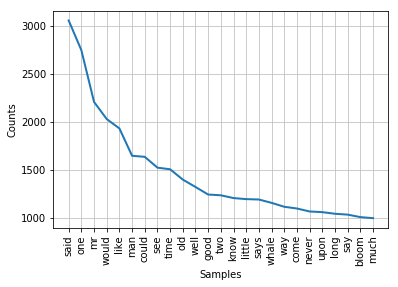

In [7]:
freqdist = nltk.FreqDist(classic_tokens)
freqdist.plot(25)

It is apparent that using 5 books as a representation of a genre probably isn't sufficient. Observe that *whale* is the 17th most frequent word, obviously overfitting to Moby Dick. This is problematic because any book that deals with whales will be categorized as classic fiction. Getting a much larger set of books for the training set would solve this issue.

Let's explore the top 25 words for a few other genres.

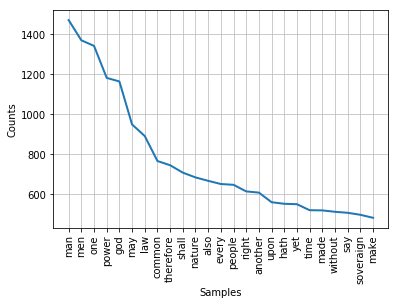

In [8]:
freqdist = nltk.FreqDist(politics_tokens)
freqdist.plot(25)

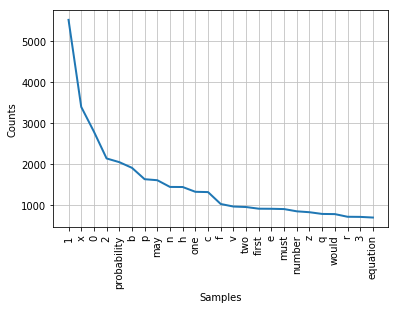

In [9]:
freqdist = nltk.FreqDist(math_tokens)
freqdist.plot(25)

From a quick glance, the plot for the political genre seems to agree with preconceived notions of political words. The plot for the mathematics genre makes it obvious that we should be able to easily identify these books since they have a large percentage of tokens that are just letters and numbers, specifically *1*, *x*, and *0*.

## Predictor
Let's first write the function and go through a few of the details before using it.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd
from sklearn.preprocessing import normalize

In [11]:
total_strings = [' '.join(classic_tokens),
                 ' '.join(scifi_tokens),
                 ' '.join(crime_tokens),
                 ' '.join(politics_tokens),
                 ' '.join(bio_tokens),
                 ' '.join(math_tokens),]

In [12]:
def genre_similarity(filename, title):
    cur_token = clean_tokenize(filename)
    cur_strings = total_strings.copy()
    cur_strings.append(' '.join(cur_token))
    
    tfidf = TfidfVectorizer()
    genre_csr_mat = tfidf.fit_transform(cur_strings)
    model = NMF(n_components=3)
    model.fit(genre_csr_mat)
    nmf_features = model.transform(genre_csr_mat)
    norm_features = normalize(nmf_features)
    
    df = pd.DataFrame(norm_features, index=[*list(genres_dict.keys()), title])
    similarities = df.dot(df.loc[title])
    print(similarities.nlargest(7))

We pass in the filename and desired title of the book whose genre we are predicting. Then, the book is added to the list containing the words of every genre. TfidfVectorizer is used to create the tf-idf matrix (which is stored as a sparse matrix for performance reasons). We run the NMF algorithm on the tf-idf matrix, making sure to normalize the results so that the genres with fewer words aren't overpowered by the other genres solely because of raw word count. Lastly, we take the dot product (representing the cosine similarity) between the normalized NMF features of the book of interest with the normalized NMF features of the genres. The only hyper-parameter in our function is the number of components in the NMF algorithm.

The results are printed out in order of most similar genre to least (with the book itself automatically getting 1.0000). The scores are not probabilities, rather, they are a version of the cosine similarity metric, ranging from 0 to 1.

As a first test, let's use a mathematics books, which the function should easily be able to identify as such: "A First Book in Algebra" by Wallace C. Boyden

In [13]:
genre_similarity('books_test/13309.txt', 'A First Book in Algebra')

A First Book in Algebra    1.000000
Mathematics                0.089910
Biography                  0.021788
Classic Fiction            0.014969
Science Fiction            0.000000
Crime                      0.000000
Politics                   0.000000
dtype: float64


Nice! The function worked great and mathematics is the highest scorer out of all the genres. Let's turn our attention to politics and use "The Federalist Papers" by Alexander Hamilton, John Jay, and James Madison.

In [14]:
genre_similarity('books_test/18.txt', 'The Federalist Papers')

The Federalist Papers    1.000000
Politics                 0.993682
Biography                0.769261
Classic Fiction          0.158235
Mathematics              0.101860
Science Fiction          0.001538
Crime                    0.000000
dtype: float64


Awesome, there is a very high similarity score with the politics genre. However, one of the 5 training books we used was "The Declaration of Independence of The United States of America" by Thomas Jefferson, written around the same time/place as The Federalist Papers. Thus, it is possible that the high similarity is due to the period and not necessarily the subject of the words themselves. For this reason, let's test a much older political document: "Politics: A Treatise on Government" by Aristotle

In [15]:
genre_similarity('books_test/6762.txt', 'Politics: A Treatise on Government')

Politics: A Treatise on Government    1.000000
Politics                              0.996311
Biography                             0.590749
Classic Fiction                       0.180402
Mathematics                           0.085821
Science Fiction                       0.000465
Crime                                 0.000000
dtype: float64


Great, once again the function correctly predicted Politics as the genre. Let's now move to the biography genre with: Life of Harriet Beecher Stowe by Harriet Beecher Stowe

In [16]:
genre_similarity('books_test/6702.txt', 'Life of Harriet Beecher Stowe')

Life of Harriet Beecher Stowe    1.000000
Biography                        0.999912
Politics                         0.944810
Classic Fiction                  0.608663
Crime                            0.318949
Science Fiction                  0.318933
Mathematics                      0.001031
dtype: float64


Once again, the function has correctly marked Biography as the most likely genre. It is interesting to note that the Politics genre also got a very high score, which makes sense considering the life of Harriet Beecher Stowe has far reaching implications in the political developments of the time. 

Let's take a look at some books whose genre is not as clear cut. For example "The Woman in White" by Wilkie Collins (1859) is considered one of the earliest mystery books. It has some elements of classic fiction and crime.

In [17]:
genre_similarity('books_test/583.txt', 'The Woman in White')

The Woman in White    1.000000
Science Fiction       0.999861
Crime                 0.999849
Classic Fiction       0.980024
Biography             0.600952
Mathematics           0.017383
Politics              0.000000
dtype: float64


The results indicate essentially a tie between Science Fiction and Crime, with Classic Fiction right behind them. There aren't really any science fiction elements to the story, so these results miss the mark. Let's try another tricky one. Mary Shelley's "Frankenstein" is definitely classic fiction, and has some elements of soft science fiction, although it's closer to gothic fiction or mythology and folk tales.

In [18]:
genre_similarity('books_test/84.txt', 'Frankenstein')

Frankenstein       1.000000
Biography          0.996442
Classic Fiction    0.832730
Science Fiction    0.742630
Crime              0.742630
Politics           0.663562
Mathematics        0.090482
dtype: float64


The high biography result is puzzling. However, it makes sense that the science fiction result is relatively low considering that the 5 sci-fi books we choose were by authors such as Asimov and Vonnegut who didn't have monsters in their stories.

Lastly, let's see the results for "Walden, and On The Duty Of Civil Disobedience" by Henry David Thoreau. This book is an American classic and blends many different genres. Part of it can be classified as a biography since the memoir describes his own experience in nature. Additionally, there is an abundance of philosophy and advice which can blend with certain political ideas.

In [19]:
genre_similarity('books_test/205.txt', 'Walden')

Walden             1.000000
Biography          0.993749
Classic Fiction    0.796409
Science Fiction    0.707655
Crime              0.707655
Politics           0.700547
Mathematics        0.091967
dtype: float64


## Afterword
In this simple 1-day project, we built a rudimentary genre predictor for books. While the predictor works reasonably well, it can be made much more robust through a number of additional careful considerations and experiments. First, a *much* larger sample size of labeled books would help immensely. Instead of 5 books in each genre, the top 5000 books of each genre would build a much more reliable engine by sufficiently capturing the language of the particular genre. Secondly, with more in-depth machine learning algorithms, we could properly sweep through and optimize the hyper-parameters.

Overall, this was a fun and insightful mini-project with thanks owed to Project Guttenberg as well as DataCamp.